# Setup





In [0]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Navigate to folder containing project
import os
os.chdir("drive/My Drive/COMP 551/Projects/Project3")

In [0]:
from google.colab.patches import cv2_imshow
# Function to show a single image 
def show_single_picture(img):
    """ Plot an image """
    cv2_imshow(img*255)

# InceptionResNetV2	


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import datetime
from sklearn.model_selection import train_test_split
import pandas as pd 

# Using pre-trained models
from keras.applications import VGG16, VGG19, InceptionResNetV2, Xception, NASNetLarge
from keras import datasets, optimizers
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# Read data 
x_train = pd.read_pickle("data/x_train.pkl")
x_valid = pd.read_pickle("data/x_valid.pkl")
y_train = pd.read_pickle("data/y_train.pkl")
y_valid = pd.read_pickle("data/y_valid.pkl")

# Convert training/valid images from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)
x_valid = np.stack((x_valid,x_valid,x_valid), axis=-1)

# Image dimensions 
image_size = x_train[0].shape[0]
num_channels = x_train[0].shape[2]
print("Image size: {0}\nNumber of channels: {1}".format(image_size, num_channels))

Image size: 128
Number of channels: 3


**The goal when applying data augmentation is to increase the generalizability of the model.**
Given that our network is constantly seeing new, slightly modified versions of the input data, the network is able to learn more robust features.

Reasons to use a data generator
- Real-world datasets are often too large to fit into memory.
- They also tend to be challenging, requiring us to perform data augmentation to avoid overfitting and increase the ability of our model to generalize.

Here's how the ImageDataGenerator works:
1. Accepting a batch of images used for training.
2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
3. Replacing the **original** batch with the **new, randomly transformed batch**.
4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

Keras' ImageDataGenerator executes in-place data augmentation. 
It is called "in-place" and "on-the-fly", because data augmentation is done at training time. 
If we included the original training data along with the augmented data in each batch, then the network would “see” the original training data multiple times, effectively defeating the purpose.
The entire point of the data augmentation technique described in this section is to ensure that the network sees “new” images that it has never "seen" before at each and every epoch.
To accomplish this goal we “replace” the training data with randomly transformed, augmented data.
Performing data augmentation is a form of regularization, enabling our model to generalize better. 

NOTE: we don't apply data augmentation to validation/test data, therefore we don't need a generator.

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [0]:
# Construct the training image generator to perform data augmentation (NOTE: since we are working numbers, it is important to set the rotation and the horizontal_flip to 0 and False respectively).
datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.10,
	width_shift_range=0.05, height_shift_range=0.05, shear_range=0,
	horizontal_flip=False,vertical_flip=False, fill_mode="nearest")

In [0]:
# Fit data generator on training data for ZCA whitening
datagen.fit(x_train)

In [0]:
# Verify image generated by ImageDataGenerator
for i in  datagen.flow(x=x_train,y=y_train)[0][0]:
  show_single_picture(i)

In [0]:
# Initialize number of epochs, batch_size and validation split 
WARMUP = 10
EPOCHS = 10
batch_size = 32

In [0]:
# Initialize optimizer
learning_rate = 5e-4
optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9) 

**Fine Tune Pre-Trained Models**

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [0]:
# Create a model using pretrained InceptionResNetV2	
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_size, image_size, num_channels))) # assumes data_format = "channels_last"

# Add a global spatial average pooling layer
top_network = base_model.output
top_network = Flatten()(top_network)
# Add a fully-connected layer    
top_network = Dense(128, activation='relu')(top_network)
# Add a Dropout layer
top_network = Dropout(0.25)(top_network)
# Add a fully-connected layer    
top_network = Dense(32, activation='relu')(top_network)
# Add a logistic layer with 10 classes
top_network = Dense(10, activation='softmax')(top_network)

# Create model
model = Model(inputs=base_model.input, outputs=top_network)

# Step 1: Train only the top layers (i.e. fully connected layers) which were randomly initialized. Freeze all InceptionResNetV2 layers
for layer in base_model.layers:
    layer.trainable = False

# Display trainable layers
for layer in model.layers:
  print("{}: {}".format(layer, layer.trainable))

# Compile the model (should be done ***after*** setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Print a summary of the model
model.summary()

# Train the head of the network on new data for a few epochs (all other layers are frozen) -- this will allow the new FC layers to start to become initialized with actual "learned" values versus pure random
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), validation_data=(x_valid,y_valid), steps_per_epoch=len(x_train)//batch_size, epochs=WARMUP)














219062272/219055592 [==============================] - 6s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<keras.engine.input_layer.InputLayer object at 0x7fd07a3f8240>: False
<keras.layers.convolutional.Conv2D object at 0x7fd07a3f8320>: False
<keras.layers.normalization.BatchNormalization object at 0x7fd07a3f8588>: False
<keras.layers.core.Activation object at 0x7fd07a3f89e8>: False
<keras.layers.convolutional.Conv2D object at 0x7fd07a3f8630>: False
<keras.layers.normalization.BatchNormalization object at 0x7fd06a31deb8>: False
<keras.layers.core.Activation object at 0x7fd06a337f60>: False
<keras.layers.convolutional.Conv2D object at 0x7fd06a340a58>: False
<keras.layers.normalization.BatchNormalization object at 0x7fd06a2f8748>: False
<keras.layers.core.Activation object at 0x7fd06a2f86d8>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fd06a2ffef0>: False
<keras.layers.convolutional.Conv2D

In [0]:
# Save model with FC layer adapted to modified mnist dataset
model.save("models/InceptionResNetV2_fully_connected_layer_trained_128_02_32_10.h5")

In [0]:
# Load model with FC layer adapted to modified mnist dataset
from keras.models import load_model 
model = load_model("models/InceptionResNetV2_09492_sgd_learning_rate0001_30epochs_bs256.h5")














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




At this point, the top layers are well trained and we can start fine-tuning convolutional layers from InceptionResNetV2. 

In [0]:
# Visualize layer names and layer indices to see how many layers we should unfreeze for InceptionResNetV2
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d_1 True
2 batch_normalization_1 True
3 activation_1 True
4 conv2d_2 True
5 batch_normalization_2 True
6 activation_2 True
7 conv2d_3 True
8 batch_normalization_3 True
9 activation_3 True
10 max_pooling2d_1 True
11 conv2d_4 True
12 batch_normalization_4 True
13 activation_4 True
14 conv2d_5 True
15 batch_normalization_5 True
16 activation_5 True
17 max_pooling2d_2 True
18 conv2d_9 True
19 batch_normalization_9 True
20 activation_9 True
21 conv2d_7 True
22 conv2d_10 True
23 batch_normalization_7 True
24 batch_normalization_10 True
25 activation_7 True
26 activation_10 True
27 average_pooling2d_1 True
28 conv2d_6 True
29 conv2d_8 True
30 conv2d_11 True
31 conv2d_12 True
32 batch_normalization_6 True
33 batch_normalization_8 True
34 batch_normalization_11 True
35 batch_normalization_12 True
36 activation_6 True
37 activation_8 True
38 activation_11 True
39 activation_12 True
40 mixed_5b True
41 conv2d_16 True
42 batch_normalization_16 True
43 activation_16 True
44 c

In [0]:
# Unfreeze all CONV layers in the base model
for layer in model.layers[1:]:
  layer.trainable = True

# Display trainable layers
for layer in model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7fd2c40ec438>: False
<keras.layers.convolutional.Conv2D object at 0x7fd2c40ec4a8>: True
<keras.layers.normalization.BatchNormalization object at 0x7fd2c40ec518>: True
<keras.layers.core.Activation object at 0x7fd2c40ec6a0>: True
<keras.layers.convolutional.Conv2D object at 0x7fd2c40ec908>: True
<keras.layers.normalization.BatchNormalization object at 0x7fd2c40ec940>: True
<keras.layers.core.Activation object at 0x7fd2c40ecac8>: True
<keras.layers.convolutional.Conv2D object at 0x7fd2c40ecbe0>: True
<keras.layers.normalization.BatchNormalization object at 0x7fd2c40ecc18>: True
<keras.layers.core.Activation object at 0x7fd2c40ecda0>: True
<keras.layers.pooling.MaxPooling2D object at 0x7fd2c40eceb8>: True
<keras.layers.convolutional.Conv2D object at 0x7fd2c40ecef0>: True
<keras.layers.normalization.BatchNormalization object at 0x7fd2c40f9160>: True
<keras.layers.core.Activation object at 0x7fd2c40f9278>: True
<keras.layers.convolutional.Con

In [0]:
# Recompile the model for these modifications to take effect. SGD is used with a low learning rate to fine tune.
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Print a summary of the model
model.summary()

# Train model again (this time fine-tuning all InceptionResNetV2 blocks alongside the top Dense layers)
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), validation_data=(x_valid,y_valid), steps_per_epoch=len(x_train)//batch_size, epochs=EPOCHS)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
# Save the model
model.save('models/InceptionResNetV2_{0}_sgd_lr{1}_{2}epochs_bs{3}.h5'.format(max(history.history['val_acc']), learning_rate, EPOCHS, batch_size))

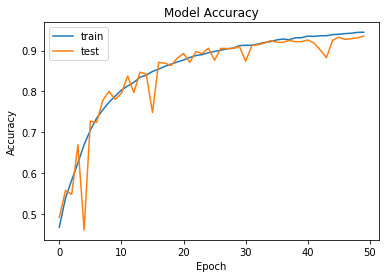

In [0]:
# Plot history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/InceptionResNetV2_{0}acc_sgd_lr{1}_{2}epochs_bs{3}.png'.format(max(history.history['val_acc']), learning_rate, EPOCHS, batch_size))
plt.show()

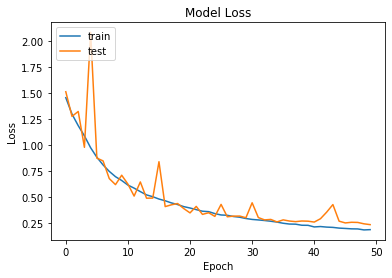

In [0]:
# Plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/InceptionResNetV2_{0}loss_sgd_lr{1}_{2}epochs_bs{3}.png'.format(min(history.history['val_loss']), learning_rate, EPOCHS, batch_size))
plt.show()

In [0]:
# Load full dataset to train final model 
x_train = pd.read_pickle("data/preprocessed_train_max_x.pkl")
y_train = pd.read_csv("data/train_max_y.csv")["Label"]

# Transform data from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)

# Load final model
from keras.models import load_model
model = load_model("models/)

# Fit on entire dataset
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, epochs=EPOCHS)

Epoch 1/30
195/195 [==============================] - 133s 682ms/step - loss: 0.0737 - acc: 0.9841
Epoch 2/30
195/195 [==============================] - 129s 664ms/step - loss: 0.0685 - acc: 0.9842
Epoch 3/30
195/195 [==============================] - 130s 667ms/step - loss: 0.0621 - acc: 0.9856
Epoch 4/30
195/195 [==============================] - 130s 668ms/step - loss: 0.0617 - acc: 0.9857
Epoch 5/30
195/195 [==============================] - 129s 662ms/step - loss: 0.0589 - acc: 0.9859
Epoch 6/30
195/195 [==============================] - 130s 668ms/step - loss: 0.0539 - acc: 0.9864
Epoch 7/30
195/195 [==============================] - 130s 667ms/step - loss: 0.0529 - acc: 0.9871
Epoch 8/30
195/195 [==============================] - 129s 664ms/step - loss: 0.0515 - acc: 0.9874
Epoch 9/30
195/195 [==============================] - 130s 666ms/step - loss: 0.0507 - acc: 0.9878
Epoch 10/30
195/195 [==============================] - 129s 663ms/step - loss: 0.0503 - acc: 0.9878
Epoch 11/

In [0]:
# Save final model 
model.save('models/InceptionResNetV2_final.h5')

In [0]:
def predict(model):
  """Method that takes as input a model and stores its predictions in a csv file."""
  import datetime

  test_img = pd.read_pickle("data/preprocessed_test_max_x.pkl")

  # Convert tests images from grayscale to rgb (3 channels)
  test_img = np.stack((test_img,test_img,test_img), axis=-1)

  # Predict 
  preds = model.predict(test_img).argmax(axis=-1)

  # Create DataFrame with predictions
  df = pd.DataFrame({"Id": list(range(len(preds))), "Label": preds})

  # Save predictions 
  df.to_csv("predictions/predictions{}.csv".format(datetime.datetime.now()), index=False)

  return preds 

In [0]:
# Generate predictions
preds = predict(model)